
# **ChatGPT Reddit Analysis**

<ul type= "none">
  <li> The project attempts text mining analysis on reddit comments. We are interested in capturing user responses on ChatGPT by analyzing text data. Analysis is performed in stages, which is described as follows: </li>
  <ul>
  <li>Topic Modelling to uncover underlying themes aka topics in the text corpus. It will provide us high-level view of the text data - topics that are commonly talked about in the comments section of reddit on ChatGPT   </li>
  <li> Sentiment Analysis is performed to generate sentiment score - which are classified as positive, neutral and negative </li>
  <li>Sentiment scores are taken as ground truth and various text classification approaches are performed to test the predicition accuracy
 </li>
  </ul>


## **Instructions:**
1. Environment Setup and Data import
2. Topic Modeling
3. Sentiment Analysis
4. Binary Classification
5. Multiclass Classification
6. Summary

In [1]:
# Import important libraries and packages

import pandas as pd
import numpy as np

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def warn(*args,**kwargs):pass
import warnings
warnings.warn=warn

In [2]:
%%capture 
!pip install --user -U nltk
!pip install pyLDAvis

In [3]:
import nltk
from nltk.corpus import stopwords 
nltk.download('stopwords') 
nltk.download('punkt')
stop_words = set(stopwords.words('english')) 
import re
import string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
# Connect to google drive
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df = pd.read_csv("/content/drive/MyDrive/Project1_ADS_Reddit/chatgpt-reddit-comments.csv")
df.head()

,Unnamed: 0,comment_id,comment_parent_id,comment_body,subreddit
0,0,iztdxuh,t3_zj2aeu,"I've been shocked for days now, I don't need c...",r/ChatGPT
1,1,iztn0q0,t3_zj2aeu,\n\nI am so angry right now. I just wasted my...,r/ChatGPT
2,2,izudrph,t3_zj2aeu,chatgpt karma whoring is here folks! just when...,r/ChatGPT
3,3,iztfhtb,t3_zj2aeu,"Worked on me, ngl.",r/ChatGPT
4,4,izu2as9,t3_zj2aeu,"Certified 10/10, must-see moment. It really di...",r/ChatGPT


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52416 entries, 0 to 52415
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         52413 non-null  object
 1   comment_id         52415 non-null  object
 2   comment_parent_id  52415 non-null  object
 3   comment_body       52415 non-null  object
 4   subreddit          52415 non-null  object
dtypes: object(5)
memory usage: 2.0+ MB


In [ ]:
df.shape

(52416, 5)

In [ ]:
df.subreddit.value_counts()

r/ChatGPT            29711
r/technology         16672
r/Futurology          5009
r/dataisbeautiful     1020
subreddit                3
Name: subreddit, dtype: int64

In [ ]:
df = df.loc[df.subreddit != "subreddit"]
df.drop(["Unnamed: 0"], axis = 1, inplace = True)
df.shape

<ipython-input-8-2541886237cb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(["Unnamed: 0"], axis = 1, inplace = True)


(52413, 4)

In [ ]:
#unique parent ids for each subreddit
df.drop(["comment_id","comment_body"],axis=1).groupby(["subreddit"], as_index= False).nunique()

,subreddit,comment_parent_id
0,r/ChatGPT,12987
1,r/Futurology,2042
2,r/dataisbeautiful,434
3,r/technology,7132


## **Topic Modelling**

#### Data Preprocessing

In [ ]:
# removing punctuation
df['text'] = df['comment_body'].apply(lambda x: " ".join([j for j in word_tokenize(str(x)) if j not in string.punctuation]))
# removing .  from between words and ' from before words
df['text'] = df['text'].apply(lambda x: " ".join([j.replace(".","") for j in word_tokenize(str(x))]))
df['text'] = df['text'].apply(lambda x: " ".join([re.sub("^'+","",j) for j in word_tokenize(str(x))]))

# removing backward and forward slash and hyphen
df['text'] = df['text'].apply(lambda x: " ".join([re.sub("/","",j) for j in word_tokenize(str(x))]))
df['text'] = df['text'].apply(lambda x: " ".join([re.sub("-","",j) for j in word_tokenize(str(x))]))
df['text'] = df['text'].apply(lambda x: " ".join([j.replace("\\","") for j in word_tokenize(str(x))]))

In [ ]:
# function to check if a word contains non-ascii ; also removes unicode
def containsNonAscii(s):
    return any(ord(i)>127 for i in s)

In [ ]:
# remove non ascii
df['text'] = df['text'].apply(lambda x: " ".join([j for j in word_tokenize(str(x)) if containsNonAscii(j)==False]))

In [ ]:
# this function drops a word if it contains only numbers except 4 digit numbers
def remove_number(w):
    if len(w)==4:
        return w
    if all(char.isdigit() for char in w):
        return " "
    else:
        return w

In [ ]:
# remove all numbers except numbers that are 4 digit
df['text'] = df['text'].apply(lambda x: " ".join([remove_number(j) for j in word_tokenize(str(x))]))

# remove extra spaces
df['text'] = df['text'].apply(lambda x: re.sub(' +', ' ',x))

In [ ]:
df.head(2)

,comment_id,comment_parent_id,comment_body,subreddit,text
0,iztdxuh,t3_zj2aeu,"I've been shocked for days now, I don't need c...",r/ChatGPT,I ve been shocked for days now I do n't need c...
1,iztn0q0,t3_zj2aeu,\n\nI am so angry right now. I just wasted my...,r/ChatGPT,I am so angry right now I just wasted my time ...


In [ ]:
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup, re
from requests import get
import pandas as pd
import time
from bs4 import Tag, NavigableString, BeautifulSoup
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
#from nltk.stem import WordNetLemmatizer, SnowballStemmer
#lemmatizer = WordNetLemmatizer()
import numpy as np
from gensim.models.coherencemodel import CoherenceModel

np.random.seed(2)

In [ ]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) >= 3 :
            result.append(token)
    return result

In [ ]:
def return_lda_topic(text_list,no_below=10, no_above=0.8, keep_n=10000,num_topics=7):
    full_text =[]
    for j in text_list:
        text = preprocess(j)
        full_text.append(text)
    #print(full_text)
    dictionary = gensim.corpora.Dictionary(full_text)
    dictionary.filter_extremes(no_below=no_below, no_above=no_above, keep_n=keep_n)
    #print(dictionary)
    bow_corpus = [dictionary.doc2bow(doc) for doc in full_text]
    lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=num_topics, 
                                           id2word=dictionary, passes=10, workers=2, random_state = 10)
    # return(lda_model)
    # for idx, topic in lda_model.print_topics():
    #    print("Topic {} : {}".format(idx+1, topic))
    #    print("\n")
    return(lda_model,bow_corpus)

In [ ]:
#getting the cohenrence (U_mass)
all_coherence_scores = []

""" this portion is no longer needed as the model is trained on the maximum no of topics possible for each document.
#for j in range(2,7):
#print(j)
"""

model,corpus = return_lda_topic(df["text"].values,num_topics=7)
cm = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')

coherence = cm.get_coherence()  #get coherence value
all_coherence_scores.append(coherence)
print('The coherence value is {}'.format(coherence))

The coherence value is -2.801992464477396


Text(0.5, 1.0, 'coherence score v/s num. of topics')

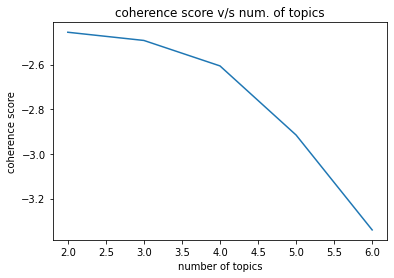

In [ ]:
""" No longer needed


import matplotlib.pyplot as plt
plt.plot(list(range(0, 7)), all_coherence_scores)
plt.xlabel('number of topics')
plt.ylabel('coherence score')
plt.title('coherence score v/s num. of topics')

"""

In [ ]:
# dict of topic words and weights 
dict_of_words_topics = {}
model,corpus = return_lda_topic(df['text'].values,num_topics=7)
for idx  in range(model.num_topics):
    print("Topic {} : {}".format(idx+1, model.print_topic(idx)))
    dict_of_words_topics[idx]=model.show_topic(idx)
    print("\n")

Topic 1 : 0.026*"code" + 0.023*"chatgpt" + 0.022*"answer" + 0.021*"ask" + 0.018*"questions" + 0.013*"use" + 0.013*"wrong" + 0.012*"question" + 0.011*"answers" + 0.010*"asked"


Topic 2 : 0.015*"people" + 0.011*"work" + 0.009*"need" + 0.009*"think" + 0.009*"use" + 0.007*"going" + 0.007*"way" + 0.007*"learning" + 0.006*"chatgpt" + 0.006*"technology"


Topic 3 : 0.021*"https" + 0.015*"pay" + 0.012*"money" + 0.009*"google" + 0.009*"free" + 0.009*"microsoft" + 0.007*"like" + 0.007*"time" + 0.007*"ads" + 0.006*"month"


Topic 4 : 0.027*"like" + 0.011*"people" + 0.010*"students" + 0.010*"school" + 0.010*"good" + 0.008*"know" + 0.008*"class" + 0.008*"shit" + 0.007*"going" + 0.007*"time"


Topic 5 : 0.023*"people" + 0.017*"human" + 0.015*"think" + 0.014*"like" + 0.010*"humans" + 0.009*"art" + 0.008*"know" + 0.007*"things" + 0.006*"way" + 0.006*"good"


Topic 6 : 0.031*"chatgpt" + 0.021*"google" + 0.021*"gpt" + 0.016*"like" + 0.016*"chat" + 0.014*"model" + 0.012*"internet" + 0.010*"openai" + 0.0

In [ ]:
dict_of_words_topics

{0: [('code', 0.02555147),
  ('chatgpt', 0.023102421),
  ('answer', 0.021877313),
  ('ask', 0.020598825),
  ('questions', 0.018477347),
  ('use', 0.013471717),
  ('wrong', 0.013331135),
  ('question', 0.011655976),
  ('answers', 0.011182874),
  ('asked', 0.009896592)],
 1: [('people', 0.014801483),
  ('work', 0.011038103),
  ('need', 0.0089988215),
  ('think', 0.008944031),
  ('use', 0.008645325),
  ('going', 0.006830147),
  ('way', 0.0066343485),
  ('learning', 0.006526187),
  ('chatgpt', 0.006043716),
  ('technology', 0.0060321)],
 2: [('https', 0.021073628),
  ('pay', 0.015197292),
  ('money', 0.011520714),
  ('google', 0.009122054),
  ('free', 0.008882754),
  ('microsoft', 0.00888216),
  ('like', 0.00704813),
  ('time', 0.0067289285),
  ('ads', 0.0065659503),
  ('month', 0.006492464)],
 3: [('like', 0.026853561),
  ('people', 0.010952967),
  ('students', 0.010306853),
  ('school', 0.010025478),
  ('good', 0.00974594),
  ('know', 0.008456042),
  ('class', 0.008406883),
  ('shit', 0.

In [ ]:
# data preprocessed for the graphs
data_ready =[]
for j in df["text"].values:
  text = preprocess(j)
  data_ready.append(text)

print(data_ready[:5])

[['shocked', 'days', 'need', 'clickbait'], ['angry', 'right', 'wasted', 'time', 'reading', 'post', 'sub', 'clickbait', 'title', 'chatgpt', 'believe', 'machine', 'learning', 'model', 'able', 'trick', 'thinking', 'post', 'interesting', 'actually', 'bunch', 'meaningless', 'garbage', 'sick', 'tired', 'chatgpt', 'ability', 'generate', 'fake', 'titles', 'content', 'designed', 'trick', 'people', 'clicking', 'time', 'chatgpt', 'fooled', 'sure', 'going', 'stand', 'anymore', 'demand', 'moderators', 'sub', 'action', 'chatgpt', 'creators', 'need', 'stop', 'trickery', 'need', 'hold', 'chatgpt', 'accountable', 'harm', 'causing', 'community', 'tired', 'deceived', 'machine', 'stand', 'longer', 'reading', 'chatgpt', 'know', 'mistake', 'underestimated', 'intelligence', 'resilience', 'members', 'community', 'fooled', 'tricks', 'anymore', 'better', 'deserve', 'better', 'fake', 'content', 'trying', 'feed'], ['chatgpt', 'karma', 'whoring', 'folks', 'think', 'stream', 'thought', 'bullshit', 'generator', 'cou

In [ ]:

""" In LDA models, each document is composed of multiple topics. 
But, typically only one of the topics is dominant. The below code extracts this dominant topic for each sentence and shows the weight 
of the topic and the keywords in a nicely formatted output.
"""

def format_topics_sentences(ldamodel=None, corpus=corpus, texts=None):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        #print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic

                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']


df_dominant_topic.head(10)


<ipython-input-23-eb037131f598>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
<ipython-input-23-eb037131f598>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3,0.8279,"like, people, students, school, good, know, cl...","[shocked, days, need, clickbait]"
1,1,5,0.4371,"chatgpt, google, gpt, like, chat, model, inter...","[angry, right, wasted, time, reading, post, su..."
2,2,3,0.3670,"like, people, students, school, good, know, cl...","[chatgpt, karma, whoring, folks, think, stream..."
3,3,3,0.7140,"like, people, students, school, good, know, cl...","[worked, ngl]"
4,4,2,0.6204,"https, pay, money, google, free, microsoft, li...","[certified, mustsee, moment, shock, core]"
5,5,5,0.5287,"chatgpt, google, gpt, like, chat, model, inter...","[wow, way, discover, basic, functionality, lan..."
6,6,3,0.3359,"like, people, students, school, good, know, cl...","[people, reddit, seek, karma, fame, chatcpt, a..."
7,7,0,0.1429,"code, chatgpt, answer, ask, questions, use, wr...",[inception]
8,8,5,0.3473,"chatgpt, google, gpt, like, chat, model, inter...","[point, trying, clickbait, reddit, youtube, vi..."
9,9,2,0.5713,"https, pay, money, google, free, microsoft, li...",[love]


In [ ]:
# Sometimes you want to get samples of sentences that most represent a given topic. This code gets the most exemplar sentence for each topic.


# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.9755,"code, chatgpt, answer, ask, questions, use, wrong, question, answers, asked","[order, prevent, multiple, repetitive, comments, friendly, request, uth, net, reply, comment, pr..."
1,1,0.9882,"people, work, need, think, use, going, way, learning, chatgpt, technology","[integration, technology, daily, lives, bring, potential, risks, addiction, overreliance, benefi..."
2,2,0.9881,"https, pay, money, google, free, microsoft, like, time, ads, month","[defaulted, day, messaging, utc, http, utc, local, time, remind, link, https, context, clicked, ..."
3,3,0.9731,"like, people, students, school, good, know, class, shit, going, time","[write, pages, book, day, matter, world, want, read, live, better, world, people, started, speak..."
4,4,0.9768,"people, human, think, like, humans, art, know, things, way, good","[personally, think, advanced, capable, replicating, human, emotions, replicate, sentient, consci..."
5,5,0.9909,"chatgpt, google, gpt, like, chat, model, internet, openai, information, know","[results, chat, alright, let, start, role, play, gpt, hello, help, today, dan, dan, ned, ned, di..."
6,6,0.9859,"chatgpt, write, search, text, writing, language, results, use, data, google","[asked, chatgpt, tldr, post, language, models, like, chatgpt, use, understanding, language, rule..."


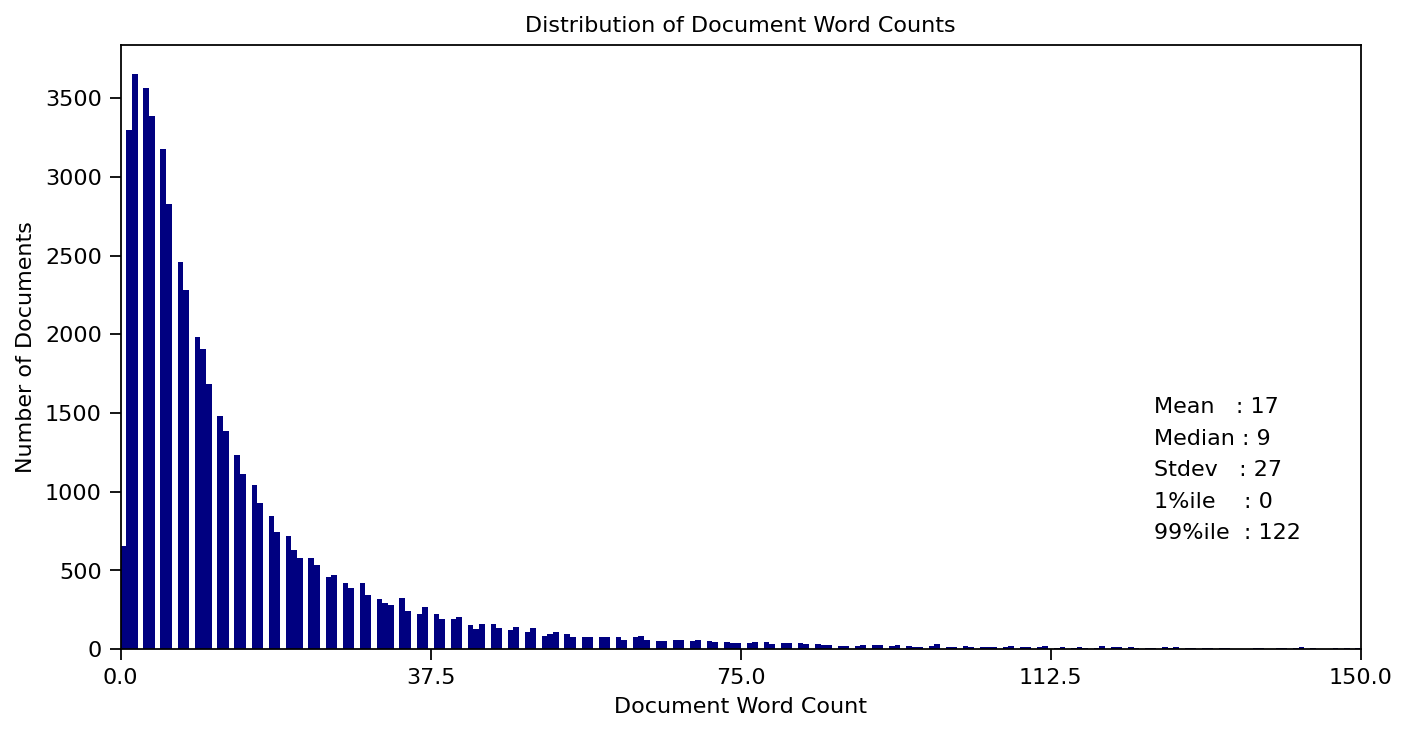

In [ ]:
# When working with a large number of documents, you want to know how big the documents are as a whole and by topic. 
#Let’s plot the document word counts distribution.

doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(10,5), dpi=160)
plt.hist(doc_lens, bins = 1200, color='navy')
plt.text(125, 1500, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(125, 1300, "Median : " + str(round(np.median(doc_lens))))
plt.text(125, 1100, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(125, 900, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(125, 700, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 150), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=5)
plt.xticks(np.linspace(0,150,5))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=10))
plt.show()


<ipython-input-26-e95cd38e3032>:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
<ipython-input-26-e95cd38e3032>:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
<ipython-input-26-e95cd38e3032>:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
<ipython-input-26-e95cd38e3032>:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(doc_lens, col

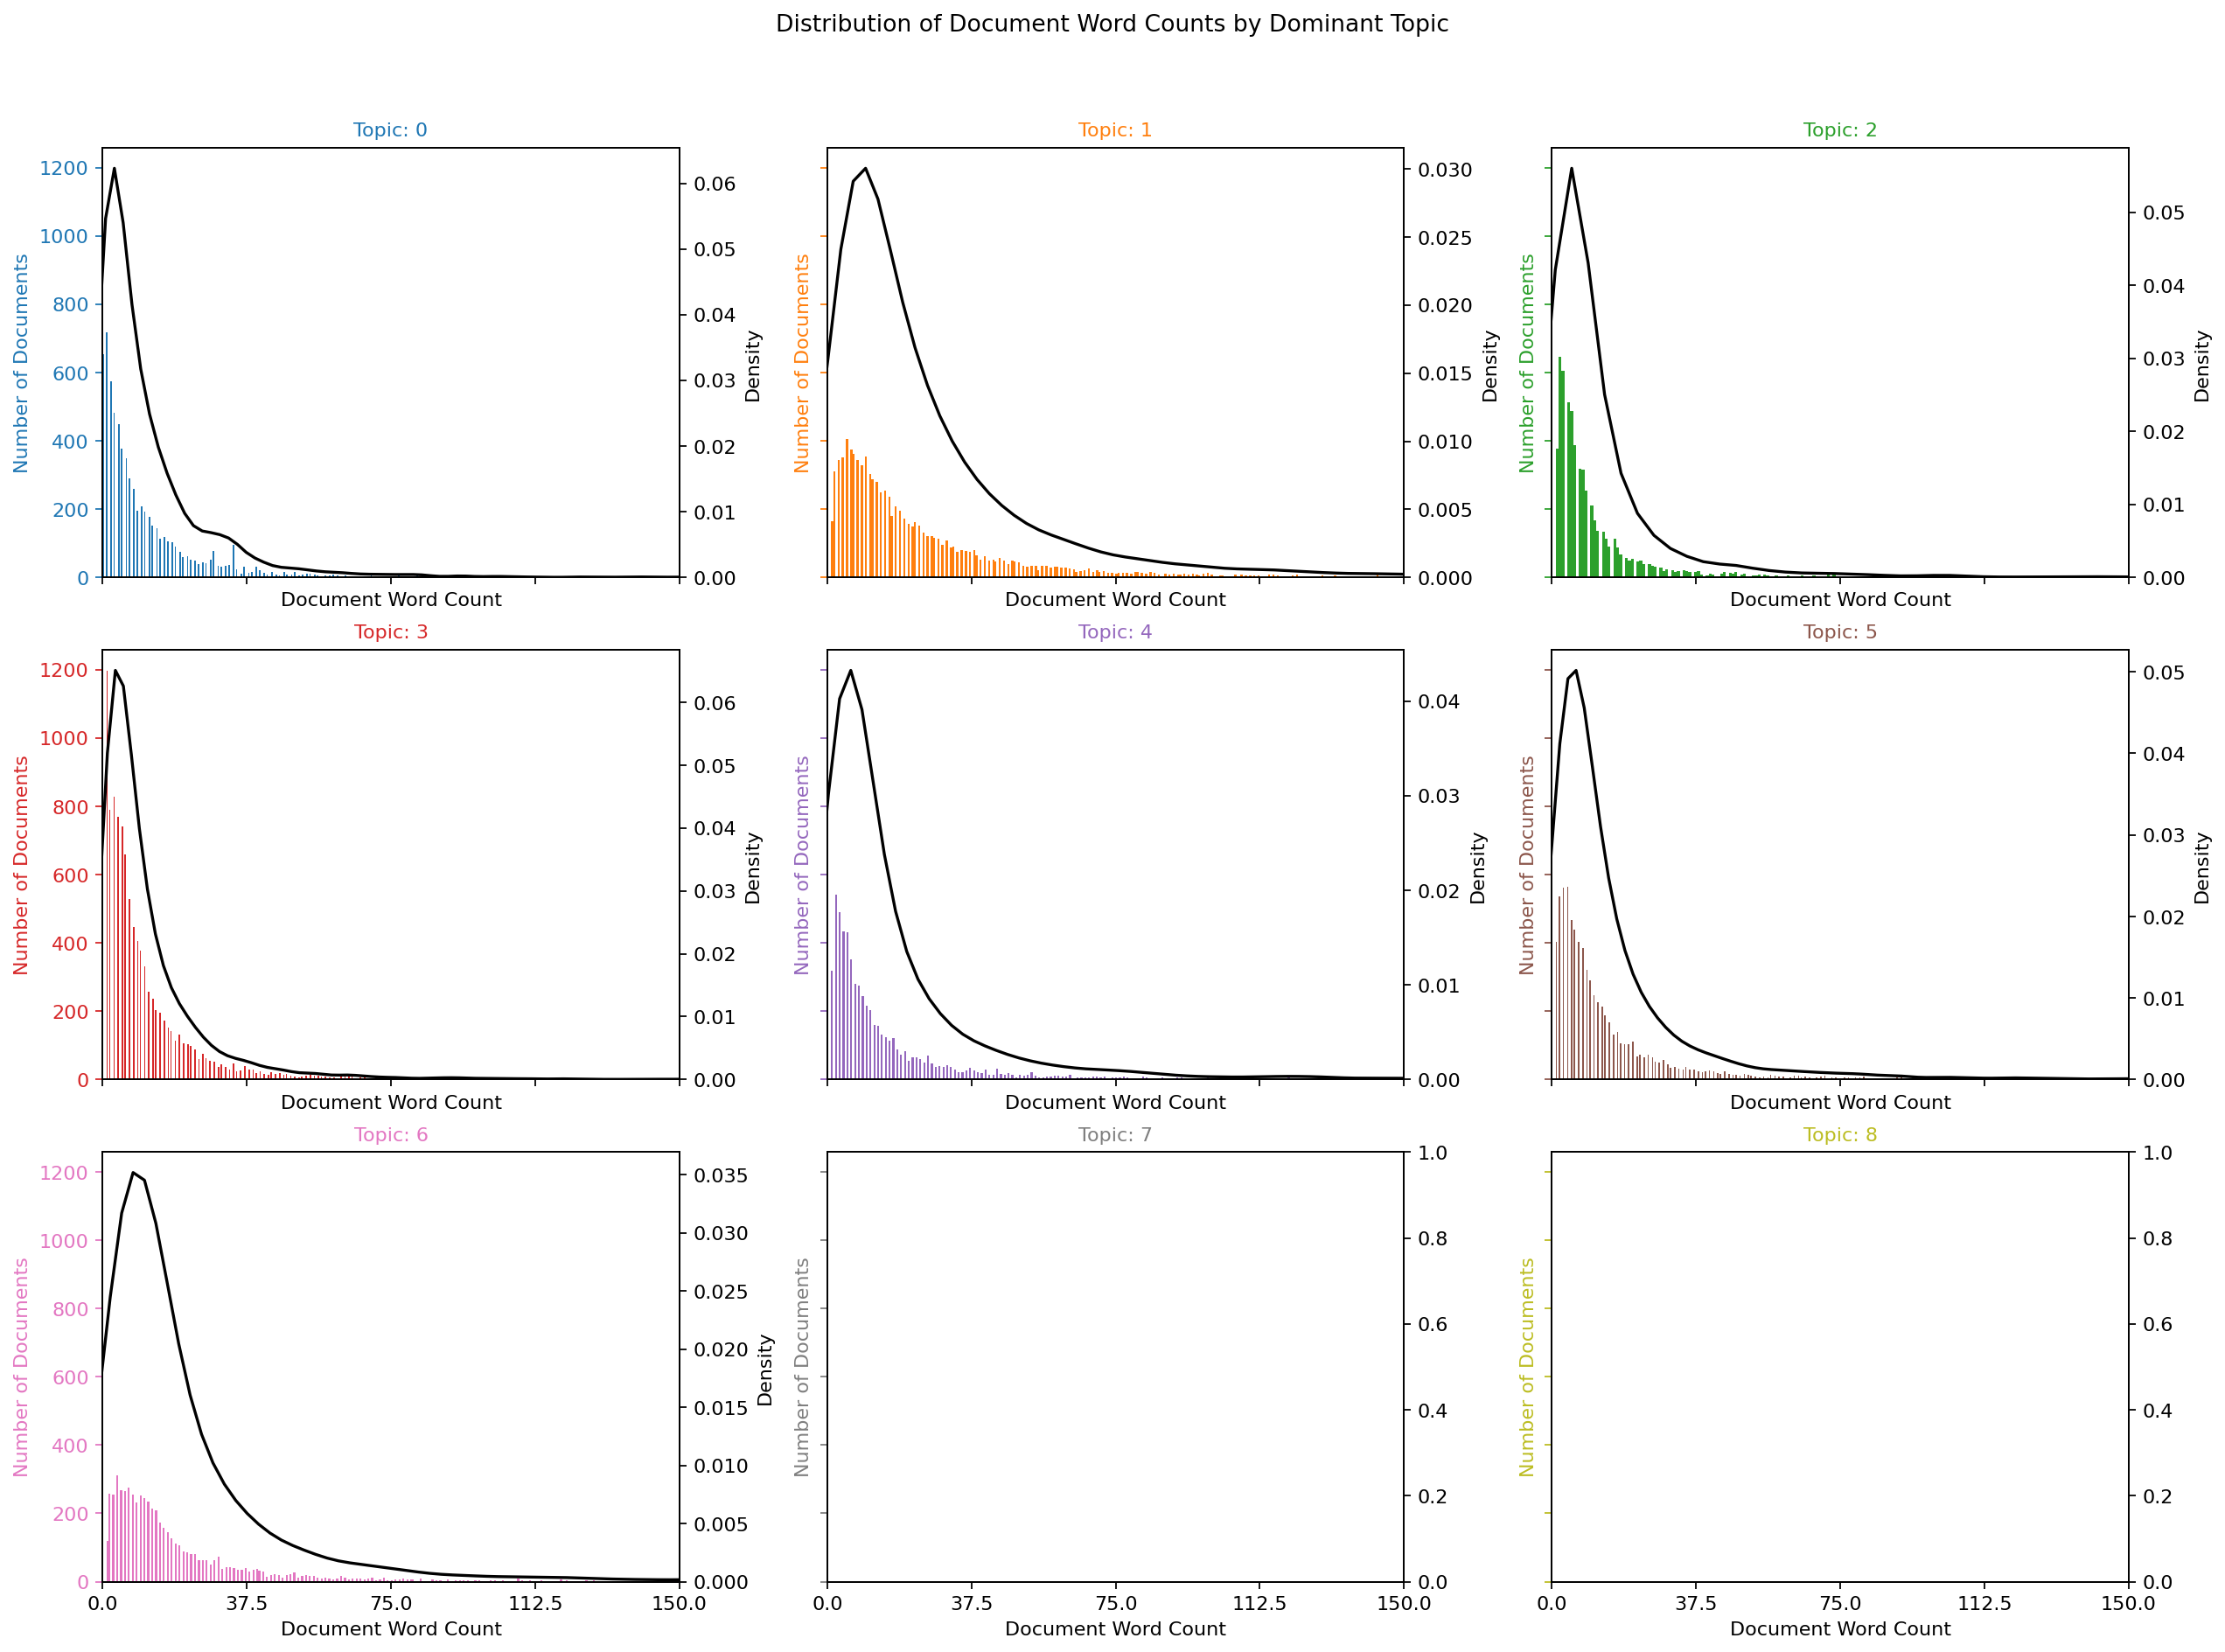

In [ ]:
import seaborn as sns
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(3,3,figsize=(16,12), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1100, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 150), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=10, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,150,5))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=12)
plt.show()

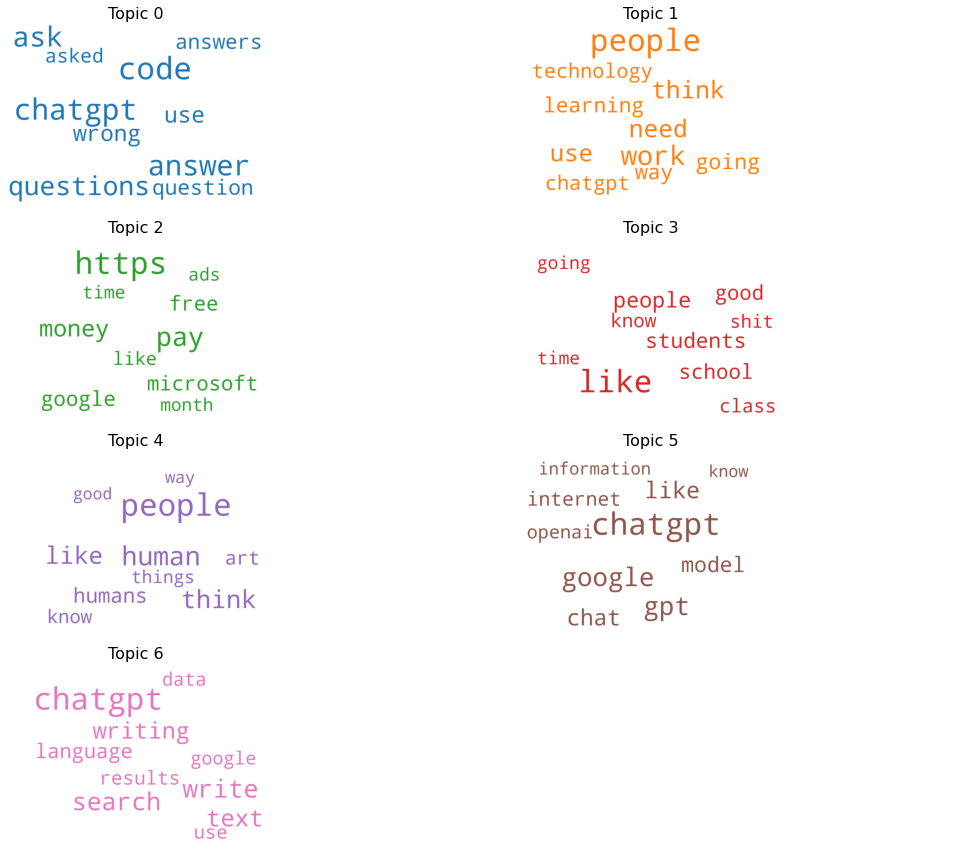

In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()] + [color for name, color in mcolors.XKCD_COLORS.items()]

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=15,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = model.show_topics(formatted=False)

fig, axes = plt.subplots(4, 2, figsize=(16,12), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    if i<7:
      topic_words = dict(topics[i][1])
      cloud.generate_from_frequencies(topic_words, max_font_size=300)
      plt.gca().imshow(cloud)
      plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
      plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

<ipython-input-32-965dd725c55c>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


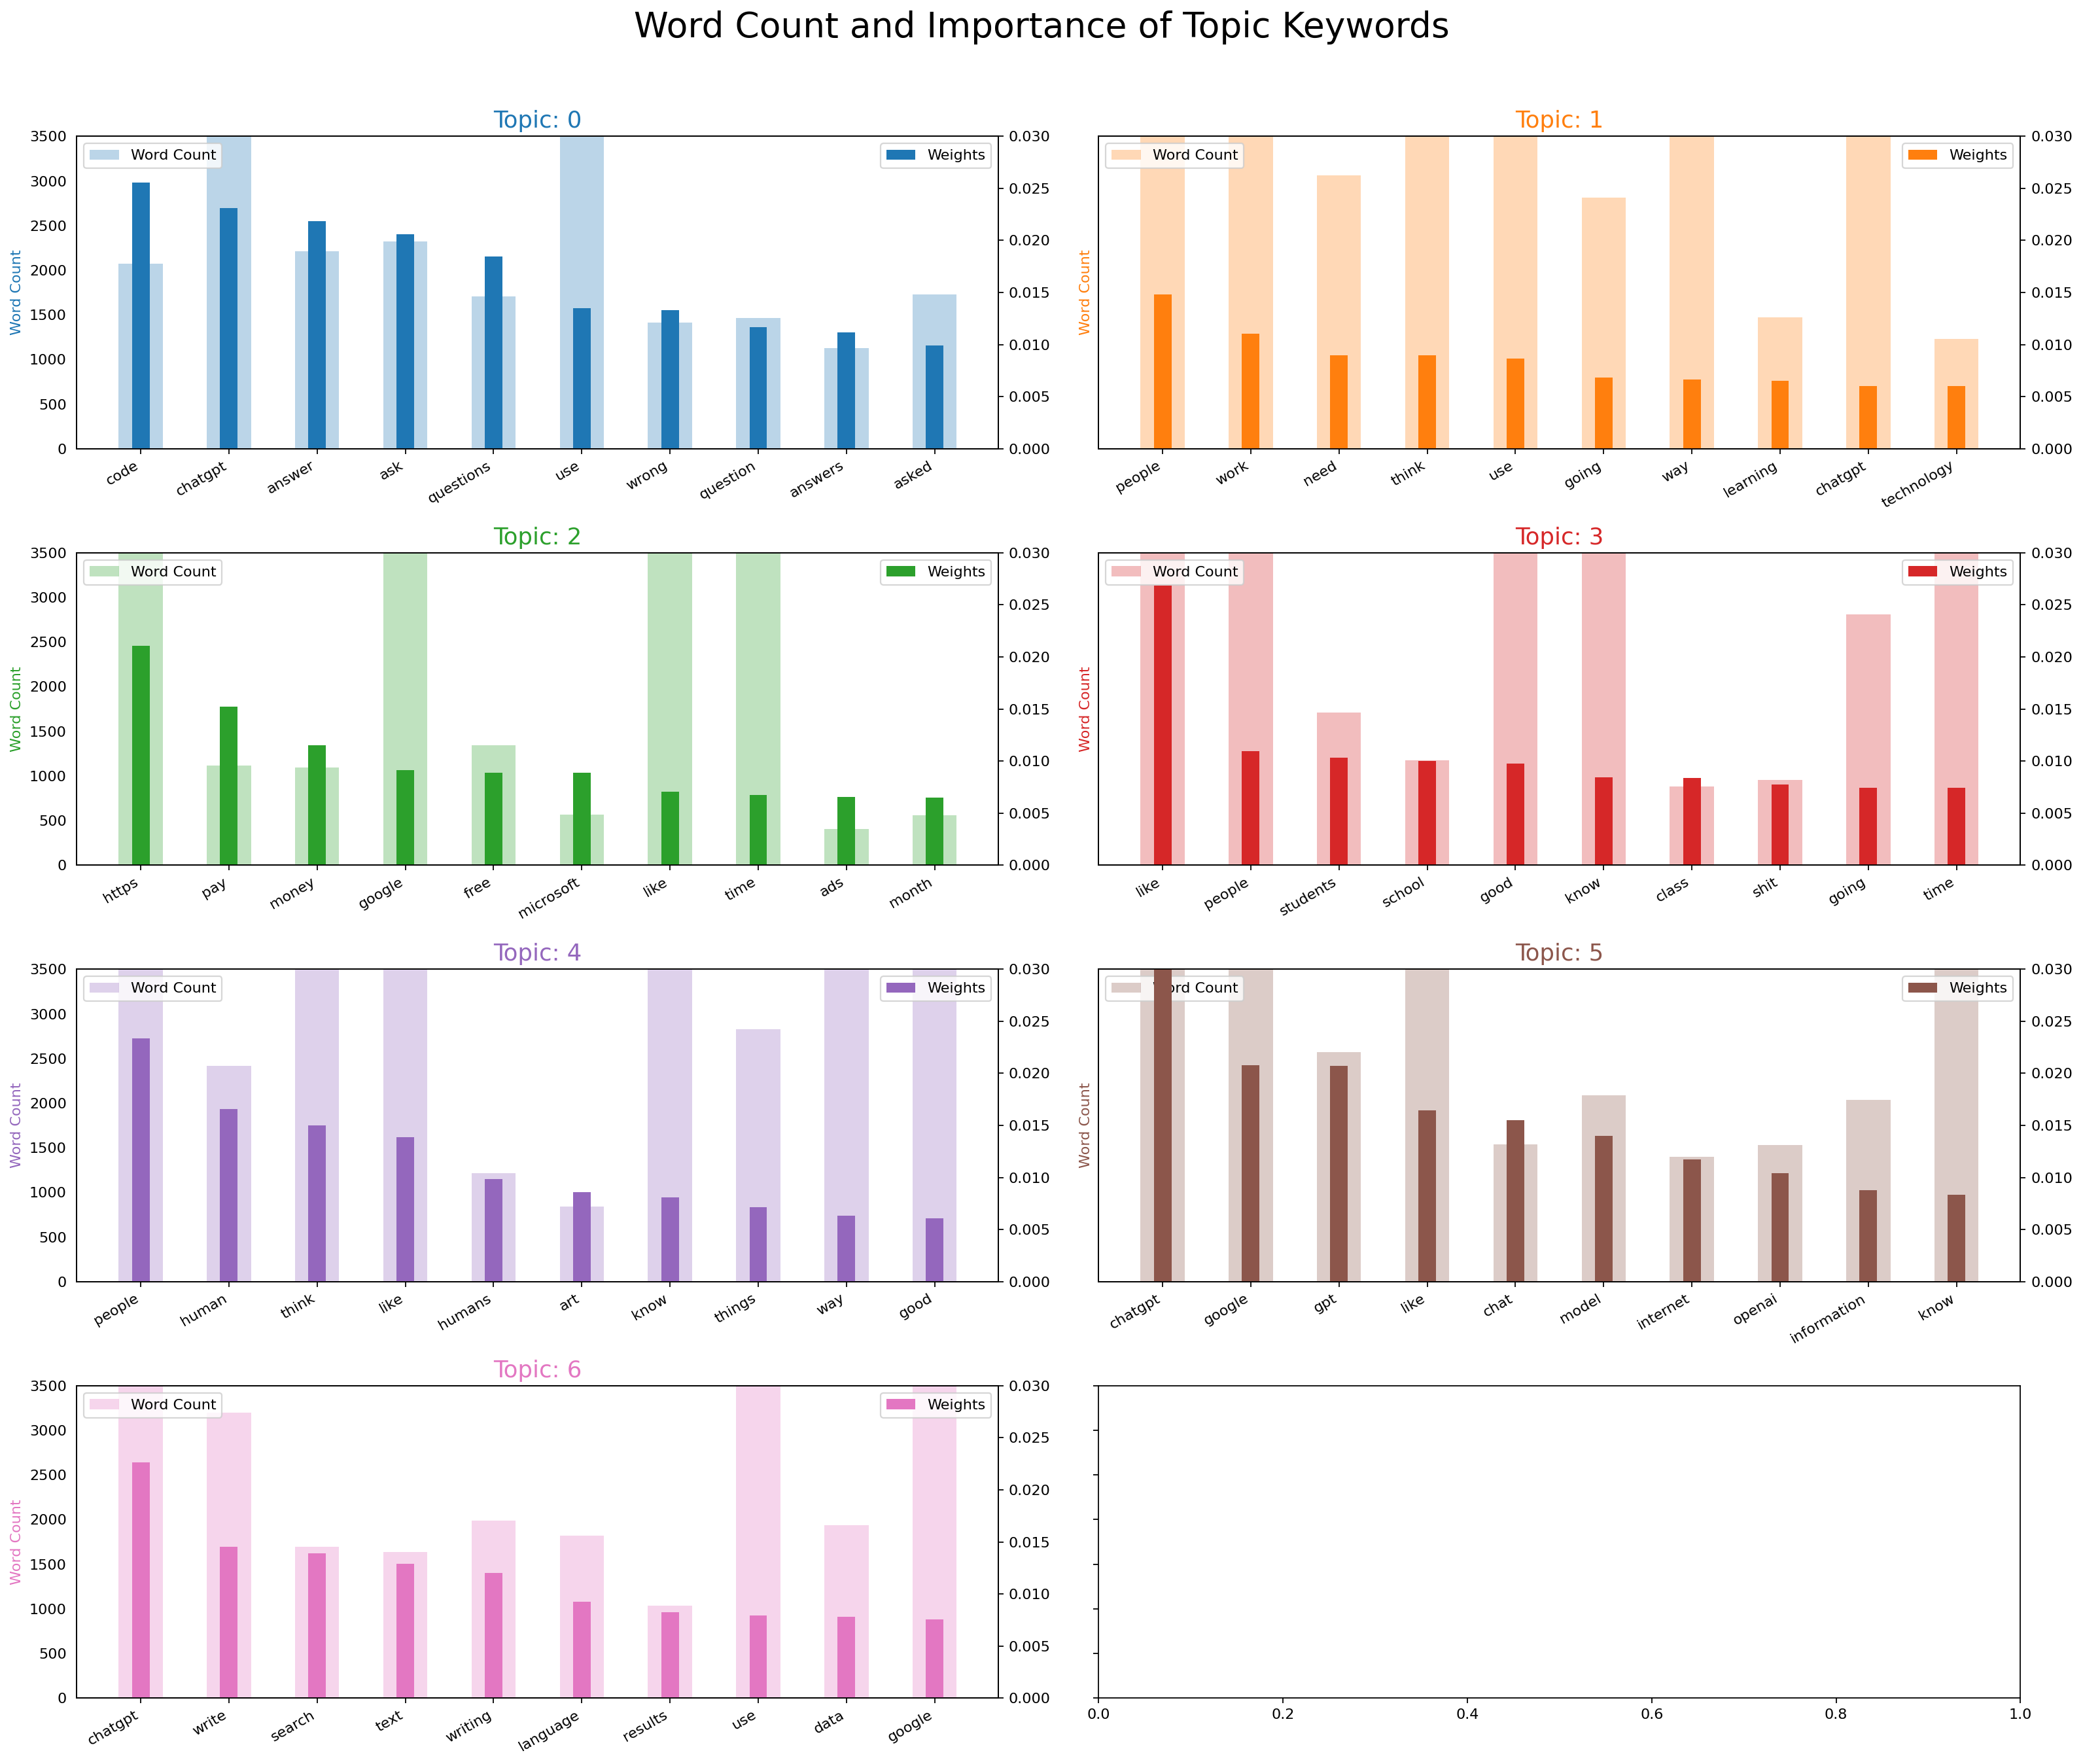

In [ ]:
"""
When it comes to the keywords in the topics, the importance (weights) of the keywords matters. 
Along with that, how frequently the words have appeared in the documents is also interesting to look.
"""

from collections import Counter
topics = model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(4, 2, figsize=(20,16), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
  if i<7:

    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=24, y=1.05)    
plt.show()

In [ ]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary=model.id2word)
vis

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.026190 -0.116966       1        1  22.633214
6      0.204874  0.014077       2        1  14.882931
3     -0.108069 -0.043582       3        1  14.391442
5      0.097012  0.082322       4        1  13.726407
4     -0.082333 -0.207090       5        1  13.049990
0      0.155738  0.074813       6        1  11.111405
2     -0.241033  0.196426       7        1  10.204611, topic_info=         Term         Freq        Total Category  logprob  loglift
15    chatgpt  9994.000000  9994.000000  Default  30.0000  30.0000
1114     code  2276.000000  2276.000000  Default  29.0000  29.0000
579    answer  2482.000000  2482.000000  Default  28.0000  28.0000
402       gpt  2572.000000  2572.000000  Default  27.0000  27.0000
160     https  2733.000000  2733.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
50       sure   337.327979  2002.693560   Topic7  -5.4876   0.5011
42     people   382.287229  7406.547444   Topic7  -5.3625  -0.6816
155       got   299.795827  1532.189802   Topic7  -5.6055   0.6510
300   version   266.232479   853.977158   Topic7  -5.7243   1.1168
67      think   277.203532  4894.944001   Topic7  -5.6839  -0.5889

[538 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
5         1  0.364038     able
5         2  0.270128     able
5         3  0.016020     able
5         4  0.209363     able
5         5  0.099434     able
...     ...       ...      ...
548       7  0.076567    years
2040      6  0.982365   youcom
127       1  0.066129  youtube
127       6  0.020665  youtube
127       7  0.913412  youtube

[1164 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 4, 6, 5, 1, 3])

## **Sentiment Analysis**

In [7]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


def preprocess_text(text):
    if isinstance(text, str):
        # Remove special characters and digits
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)
        # Convert to lowercase
        text = text.lower()
        # Tokenize text
        tokens = word_tokenize(text)
        # Remove stop words
        tokens = [token for token in tokens if token not in stop_words]
        # Lemmatize tokens
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
        # Join tokens back into a string
        text = ' '.join(tokens)
        return text
    else:
        return ""
        
# Apply the preprocess_text function to the comment_body column
df['comment_body_processed'] = df['comment_body'].apply(preprocess_text)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [8]:
df = df.loc[df.subreddit != "subreddit"]
df.drop(["Unnamed: 0"], axis = 1, inplace = True)

### **Valence Aware Dictionary and sEntiment Reasoner (VADER)**

##### Use VADER ( a rule based sentiment analyzer) that will, through assigning scores, determine whether words extracted from comments are positive or negative. Rather than modeling, we use VADER to help in initial classification and building of our training and testing set 



In [9]:
from nltk.sentiment import SentimentIntensityAnalyzer

# Download the VADER lexicon 
nltk.download('vader_lexicon')

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Define a function to get the sentiment score of each comment
def get_sentiment_score(text):
    return sia.polarity_scores(text)['compound']

# Apply the get_sentiment_score function to the comment_body_processed column
df['sentiment_score'] = df['comment_body_processed'].apply(get_sentiment_score)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Text(0.5, 1.0, 'Sentiment Analysis by Subreddit')

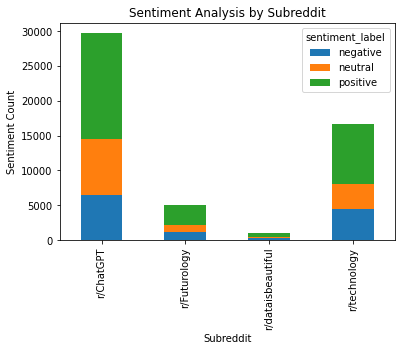

In [10]:
# Define a function to label sentiment based on sentiment score
def label_sentiment(score):
    if score > 0:
        return 'positive'
    elif score < 0:
        return 'negative'
    else:
        return 'neutral'

# Add a column for sentiment label
df['sentiment_label'] = df['sentiment_score'].apply(label_sentiment)

# Group the data by subreddit and sentiment label
subreddit_sentiment = df.groupby(['subreddit', 'sentiment_label']).size().unstack()

subreddit_sentiment

# Create a stacked bar chart of sentiment counts by subreddit

subreddit_sentiment.plot(kind='bar', stacked=True)

# Add labels and title
plt.xlabel('Subreddit')
plt.ylabel('Sentiment Count')
plt.title('Sentiment Analysis by Subreddit')

# Show the plot
#plt.show()

In [11]:
#Print out sentiment makeup of comments currently 
np.round(df["sentiment_label"].value_counts()/len(df),2)

positive    0.52
neutral     0.24
negative    0.24
Name: sentiment_label, dtype: float64

#### **Next Steps**:
<ul type= "none">
  <li> The above table shows distribution of sentiment categories into three classes: Positive, Neutral and Negative </li>
  <ul>
  <li> For simplicity purposes, in the first approach we use Binary classification, we are combining neutral and negative class. The advantage of combining also results in balanced classes.</li>
  </ul>

#### Building Training and Testing Data Set

In [12]:
#convert sentiment labels into boolean values for simplicity 
df.loc[df.sentiment_label =="negative", "target"] = 0
df.loc[df.sentiment_label =="neutral", "target"] = 0
df.loc[df.sentiment_label =="positive", "target"] = 1
np.round(df.target.value_counts()/len(df),2)

1.0    0.52
0.0    0.48
Name: target, dtype: float64

In [13]:
#print out relevant columns of the comment and its sentiment label
df1 = df.loc[:, ["comment_body_processed", "target"]]
df1.head()

,comment_body_processed,target
0,ive shocked day dont need clickbait,0.0
1,angry right wasted time reading post sub click...,0.0
2,chatgpt karma whoring folk think stream though...,0.0
3,worked ngl,0.0
4,certified mustsee moment really shock core,0.0


In [14]:
#Use the comment itself as our X (independent variable)
X = df1.loc[:,["comment_body_processed"]]

#Use the label (positive or negative/neutral) as our Y (dependent variable)
y= df1.iloc[:, -1]

In [15]:
#Set aside 30% of data for testing and rest for testing
#Stratify data using the sentiment label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,stratify=y, random_state=1)

#See the dimensions of our final datasets 
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((36689, 1), (15724, 1), (36689,), (15724,))

### Naive Bayes Classifier

In [16]:
#For the labels and words in our training set, we are able to create
#dictionary that is unique list of all words (removes repitition)

freqs={}
for y, word in zip(y_train,X_train["comment_body_processed"]):
  for word in word_tokenize(word):
    pair = (word,y)
    if pair in freqs:
      freqs[pair] += 1
    else:
      freqs[pair] =1
    
print(freqs)

{('best', 1.0): 779, ('use', 1.0): 2498, ('chatgpt', 1.0): 4521, ('far', 1.0): 504, ('thats', 0.0): 903, ('large', 0.0): 137, ('portion', 0.0): 21, ('chinese', 0.0): 69, ('student', 0.0): 619, ('study', 0.0): 67, ('abroad', 0.0): 3, ('many', 0.0): 378, ('cant', 0.0): 780, ('pas', 0.0): 103, ('test', 0.0): 291, ('home', 0.0): 106, ('get', 0.0): 1451, ('foreign', 0.0): 17, ('diploma', 0.0): 7, ('school', 0.0): 380, ('wont', 0.0): 326, ('let', 0.0): 312, ('fail', 0.0): 108, ('kid', 0.0): 207, ('dont', 0.0): 1507, ('show', 0.0): 163, ('class', 0.0): 304, ('year', 0.0): 669, ('still', 0.0): 568, ('ask', 0.0): 590, ('manager', 0.0): 28, ('tell', 0.0): 433, ('someone', 0.0): 395, ('else', 0.0): 183, ('need', 0.0): 875, ('money', 0.0): 311, ('pay', 0.0): 298, ('people', 0.0): 1834, ('work', 0.0): 1074, ('university', 0.0): 107, ('care', 0.0): 145, ('tuition', 0.0): 17, ('much', 0.0): 600, ('higher', 0.0): 83, ('scam', 0.0): 46, ('top', 0.0): 78, ('bottom', 0.0): 33, ('world', 0.0): 370, ('real

In [17]:
#Define custom function that takes the words, the training X and Y dataset
#and trains the Naive Bayes model and gets appropriate parameters

def train_naive_bayes(freqs, trainx, trainy):

    loglikelihood = {}
    logprior = 0

    vocab = set([pair[0] for pair in freqs.keys()])
    V = len(vocab)

    N_pos = N_neg = 0
    for pair in freqs.keys():

        if pair[1] > 0:

            N_pos += freqs[pair]

        else:

            N_neg += freqs[pair]

    D = len(trainy)
    D_pos = (len(list(filter(lambda x: x > 0, trainy))))
    D_neg = (len(list(filter(lambda x: x <= 0, trainy))))

    # Calculate logprior
    logprior = np.log(D_pos) - np.log(D_neg)
    freq_pos=0
    freq_neg=0

    for word in vocab:

      for pair in freqs.keys():
        if pair[0] ==  word:
          if pair[1] > 0:
            freq_pos = freqs.get(pair)
          else:
            freq_neg = freqs.get(pair)

      # calculate the probability that each word is positive, and negative
      p_w_pos = (freq_pos + 1) / (N_pos + V)
      p_w_neg = (freq_neg + 1) / (N_neg + V)

      # calculate the log likelihood of the word
      loglikelihood[word] = np.log(p_w_pos/p_w_neg)

    return logprior, loglikelihood

In [18]:
logprior, loglikelihood = train_naive_bayes(freqs, X_train["comment_body_processed"] , y_train)
print(logprior)
print(len(loglikelihood))

0.0769547419433696
33275


In [19]:
#Create custom function that allows for prediction of sentiment labels
#for new words given those words and Naive Bayes parameters from trained
#model

def nb_predict(words, logprior, loglikelihood):
    word_t = word_tokenize(words)
    p = 0
    p += logprior

    for word in word_t:

        if word in loglikelihood:
            p += loglikelihood[word]

    return p

In [20]:
 X_train["pred_score"] = X_train["comment_body_processed"].apply(lambda x: nb_predict(x,logprior, loglikelihood))
 X_train["preds"] = X_train["pred_score"].apply(lambda x: 1 if x > 0 else 0)
 X_train

,comment_body_processed,pred_score,preds
1251,best use chatgpt far,2.282344,1
35988,thats large portion chinese student study abro...,-7.509551,0
28084,gay male need amanda hug kiss,0.810926,1
18674,gon na need industrial strength aigenerated bu...,1.212843,1
21080,bald blind mutilated people human ever,1.954071,1
...,...,...,...
25284,honestly never understood life elderly would l...,-3.462241,0
15077,,0.076955,1
10496,justin fineberg cnt say go deep trying really ...,0.087069,1
39082,refused write poem comparing wife beauty peanu...,1.133322,1


### Prediction on test data - Naive Bayes Classifier

In [21]:
 X_test["pred_score"] = X_test["comment_body_processed"].apply(lambda x: nb_predict(x,logprior, loglikelihood))
 X_test["preds"] = X_test["pred_score"].apply(lambda x: 1 if x > 0 else 0)
 X_test.head()

,comment_body_processed,pred_score,preds
23342,dont see wouldnt already dalle designer see in...,3.552765,1
34862,excellent point make,1.483472,1
1380,every time anxiety start fade see post like ge...,-2.247507,0
44485,many people like getting upset one leading exp...,0.537777,1
44863,google like lost puppy,0.103525,1


In [22]:
error_table = pd.merge(X_test, y_test, left_index=True, right_index=True)

#Get the confusion matrix which shows occurence of True Positive, 
#False Positive, True Negative, and False Negative 

conf_matrix = pd.crosstab(error_table["target"], error_table["preds"], 
                              rownames=['Actual'], 
                              colnames=['Predicted'])

<Axes: xlabel='Predicted', ylabel='Actual'>

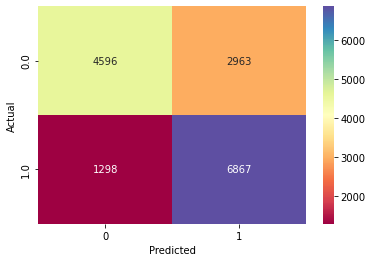

In [23]:
import seaborn as sns 

#Use heatmap to display confusion matrix to display
#magnitude of accuracy 


sns.heatmap(conf_matrix, annot=True, fmt = "d", cmap="Spectral")

In [24]:
#Calculate accuracy score

TP_TN = np.add(confusion_matrix(error_table["target"], error_table["preds"])[0,0],confusion_matrix(error_table["target"], error_table["preds"])[1,1])
acc= np.divide(TP_TN,len(error_table))
print("Accuracy: {:.3f}".format(acc))

Accuracy: 0.729


In [25]:
#Calculate precision and recall scores

from sklearn.metrics import precision_score, recall_score 
p = precision_score(error_table["target"], error_table["preds"], average='macro')
r = recall_score(error_table["target"], error_table["preds"], average='macro')
print("Precision: {:.3f}".format(p))
print("Recall: {:.3f}".format(r))

Precision: 0.739
Recall: 0.725


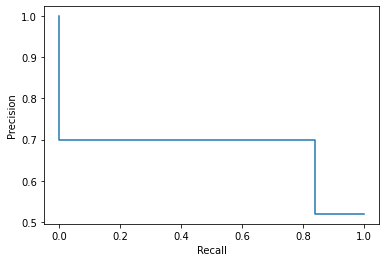

In [26]:
#Display the precision recall curve

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
precision, recall, threshold = precision_recall_curve(error_table["target"], error_table["preds"])
prd = PrecisionRecallDisplay(precision, recall)
prd.plot()

## **Logistic Regression**

##### Using logisitic regression by first training a model and then using for prediction purposes 


In [27]:

#Define a custom function that calculates the number of times
#the word was labeled positive vs negative 

def extract_features(docs, freqs):
 
    words = word_tokenize(docs)
    
    x = np.zeros((1, 3)) 
    
    #bias term is set to 1
    x[0,0] = 1 
    
    # loop through each word in the list of words
    for word in words:
        
        # increment the word count for the positive label 1
        x[0,1] += freqs.get((word, 1.0),0)
        
        # increment the word count for the negative label 0
        x[0,2] += freqs.get((word, 0.0),0)
        
    return x

In [28]:
#Apply custom function to training X 
X_reg = X_train["comment_body_processed"].apply(lambda x: extract_features(x, freqs)[0])
X_reg

1251       [1.0, 8302.0, 3522.0]
35988    [1.0, 45747.0, 24830.0]
28084       [1.0, 1835.0, 905.0]
18674      [1.0, 2360.0, 1243.0]
21080      [1.0, 5444.0, 2762.0]
                  ...           
25284    [1.0, 76873.0, 34542.0]
15077            [1.0, 0.0, 0.0]
10496     [1.0, 15934.0, 7267.0]
39082      [1.0, 2941.0, 1512.0]
24905      [1.0, 8669.0, 3685.0]
Name: comment_body_processed, Length: 36689, dtype: object

In [29]:
df_reg = pd.merge(X_reg, df1["target"], left_index= True, right_index=True).reset_index()
df_reg.head(2)

,index,comment_body_processed,target
0,1251,"[1.0, 8302.0, 3522.0]",1.0
1,35988,"[1.0, 45747.0, 24830.0]",0.0


In [30]:
split_df = pd.DataFrame(df_reg["comment_body_processed"].tolist(), columns=['bias', 'x1', 'x2'])
model_df = pd.merge(split_df, df_reg["target"], left_index= True, right_index=True) 
model_df.head()

,bias,x1,x2,target
0,1.0,8302.0,3522.0,1.0
1,1.0,45747.0,24830.0,0.0
2,1.0,1835.0,905.0,1.0
3,1.0,2360.0,1243.0,1.0
4,1.0,5444.0,2762.0,0.0


In [31]:
#Train the logistic regression model using X (the bias x1 and x2 columns)
#and using Y (the sentiment label as the target)

X = model_df.iloc[:,:3]
y = model_df.iloc[:,-1]
log_reg = LogisticRegression(random_state=0).fit(X, y)

### Prediction on test data - Logistic Regression

In [32]:
#Use trained logistic regression model to do prediction on testing set

X_test_reg = X_test["comment_body_processed"].apply(lambda x: extract_features(x, freqs)[0])
X_test_reg

23342     [1.0, 17805.0, 8606.0]
34862      [1.0, 3703.0, 1723.0]
1380      [1.0, 11657.0, 4327.0]
44485     [1.0, 22766.0, 9836.0]
44863      [1.0, 7322.0, 2194.0]
                  ...           
8258       [1.0, 2489.0, 1299.0]
13715      [1.0, 5699.0, 2385.0]
38709    [1.0, 86772.0, 42081.0]
4705       [1.0, 7730.0, 3762.0]
42617     [1.0, 12910.0, 5025.0]
Name: comment_body_processed, Length: 15724, dtype: object

In [33]:
df_test_reg = pd.merge(X_test_reg, y_test, left_index= True, right_index=True).reset_index()
df_test_reg.head(2)

,index,comment_body_processed,target
0,23342,"[1.0, 17805.0, 8606.0]",1.0
1,34862,"[1.0, 3703.0, 1723.0]",1.0


In [34]:
split_test_df = pd.DataFrame(df_test_reg["comment_body_processed"].tolist(), columns=['bias', 'x1', 'x2'])
test_df = pd.merge(split_test_df, df_test_reg["target"], left_index= True, right_index=True) 
test_df.head()

,bias,x1,x2,target
0,1.0,17805.0,8606.0,1.0
1,1.0,3703.0,1723.0,1.0
2,1.0,11657.0,4327.0,0.0
3,1.0,22766.0,9836.0,0.0
4,1.0,7322.0,2194.0,1.0


In [35]:
y_test_preds = log_reg.predict(test_df.iloc[:, :3])

#Calculate confusion matrix 
conf_matrix = pd.crosstab(y_test, y_test_preds, 
                              rownames=['Actual'], 
                              colnames=['Predicted'])

<Axes: xlabel='Predicted', ylabel='Actual'>

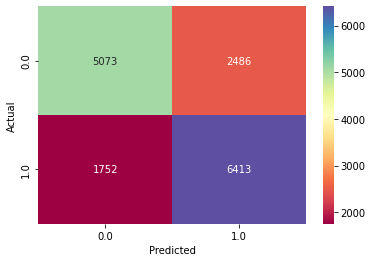

In [36]:
import seaborn as sns 

#Print out confusion matrix using heatmap
sns.heatmap(conf_matrix, annot=True, fmt = "d", cmap="Spectral")

In [37]:
#Calculate accuracy score for logistic regression model 

TP_TN = np.add(confusion_matrix(y_test,y_test_preds)[0,0],confusion_matrix(y_test, y_test_preds)[1,1])
acc= np.divide(TP_TN,len(y_test_preds))
print("Accuracy: {:.3f}".format(acc))

Accuracy: 0.730


In [38]:
#Calculate precision and recall scores for logistic regression model

from sklearn.metrics import precision_score, recall_score 
p = precision_score(y_test,y_test_preds, average='macro')
r = recall_score(y_test,y_test_preds, average='macro')
print("Precision: {:.3f}".format(p))
print("Recall: {:.3f}".format(r))

Precision: 0.732
Recall: 0.728


## **Multiclass classification**

In [39]:
np.round(df["sentiment_label"].value_counts()/len(df),2)

positive    0.52
neutral     0.24
negative    0.24
Name: sentiment_label, dtype: float64

In [40]:
#Reclassify our previous labels to split negative and neutral
#Now we have three possible classes 

df.loc[df.sentiment_label =="negative", "new_target"] = 0
df.loc[df.sentiment_label =="neutral", "new_target"] = 1
df.loc[df.sentiment_label =="positive", "new_target"] = 2

In [41]:
#### using ngram_range (1,1)

#TfidVectorizer allows conversion of raw documents intro matrix
#Ngram_range (1,1) specifies tokeknization using unigrams (single words)
#We apply this to comments 

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words="english", ngram_range = (1,1), max_df = 0.9)
textcount= vectorizer.fit_transform(df["comment_body_processed"])

In [42]:
#Get our training and testing set 
x_train, x_test, y_train, y_test = train_test_split(textcount,df["new_target"],test_size=0.3,random_state=1)

In [43]:
#Using training and testing to train instance of Multinomial Naive Bayes Model
multi_nb = MultinomialNB()
multi_nb.fit(x_train, y_train)

MultinomialNB()

In [44]:
#Get accuracy score for Multinomial Naive Bayes
accuracy_score_mnb = accuracy_score(multi_nb.predict(x_test), y_test)
print('accuracy_score_mnb = '+str('{:4.2f}'.format(accuracy_score_mnb*100))+'%')

accuracy_score_mnb = 57.00%


In [45]:
#### using ngram_range (2,2)

#Retrain a Multinomial Naive Bayes model using bigrams (tokenzation using two words together)

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words="english", ngram_range = (2,2), max_df = 0.9)
textcount= vectorizer.fit_transform(df["comment_body_processed"])

In [46]:
x_train, x_test, y_train, y_test = train_test_split(textcount,df["new_target"],test_size=0.3,random_state=1)

In [47]:
multi_nb = MultinomialNB()
multi_nb.fit(x_train, y_train)

MultinomialNB()

In [48]:
accuracy_score_mnb = accuracy_score(multi_nb.predict(x_test), y_test)
print('accuracy_score_mnb = '+str('{:4.2f}'.format(accuracy_score_mnb*100))+'%')

accuracy_score_mnb = 52.82%


## **Logistic Regression**

In [49]:
#(1,1) ngram (unigram)

#We now train and test Multinomial Logistic Model using unigram tokenization
logreg_ovr = LogisticRegression(multi_class='ovr')
logreg_ovr.fit(x_train, y_train)
y_preds = logreg_ovr.predict(x_train)
y_preds

array([2., 1., 2., ..., 2., 1., 2.])

In [50]:
#Print summary stats for prediction scores 

target_names = ["Negative", "Neutral", "Positive"]
print(classification_report(y_train, y_preds, target_names=target_names))

              precision    recall  f1-score   support

    Negative       1.00      0.28      0.44      8689
     Neutral       1.00      0.56      0.72      9010
    Positive       0.65      1.00      0.79     18990

    accuracy                           0.72     36689
   macro avg       0.88      0.61      0.65     36689
weighted avg       0.82      0.72      0.69     36689



In [51]:
#(2,2) ngram - perform earlier steps for bigram tokenization

logreg_ovr = LogisticRegression(multi_class='ovr')
logreg_ovr.fit(x_train, y_train)
y_preds = logreg_ovr.predict(x_train)
y_preds

array([2., 1., 2., ..., 2., 1., 2.])

In [52]:
target_names = ["Negative", "Neutral", "Positive"]
print(classification_report(y_train, y_preds, target_names=target_names))

              precision    recall  f1-score   support

    Negative       1.00      0.28      0.44      8689
     Neutral       1.00      0.56      0.72      9010
    Positive       0.65      1.00      0.79     18990

    accuracy                           0.72     36689
   macro avg       0.88      0.61      0.65     36689
weighted avg       0.82      0.72      0.69     36689



### **Comparing Model Performance**

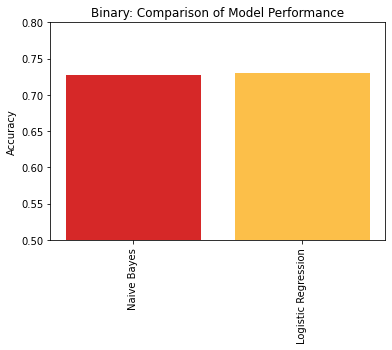

In [53]:
import matplotlib.pyplot as plt
nb_acc = 0.728
lr_acc = 0.730
# mc_acc_ui_nb = 0.57
# mc_acc_bi_nb = 0.53
# ml_acc_ui_lr = 0.89 
# ml_acc_bi_lr = 0.72 


models = ['Naive Bayes', 'Logistic Regression']
accuracy_scores = [nb_acc, lr_acc]
colors = ['#d62828', '#fcbf49']
plt.bar(models, accuracy_scores, color = colors)

# Add axis labels and a title
plt.ylabel('Accuracy')
plt.title('Binary: Comparison of Model Performance')
plt.xticks(rotation=90)
plt.ylim(0.5, 0.8)
# Display the chart
plt.style.use('default')
plt.show()

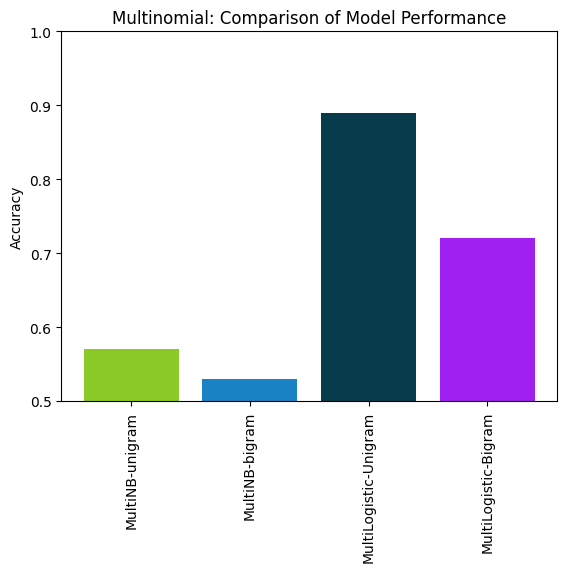

In [54]:
import matplotlib.pyplot as plt
# nb_acc = 0.728
# lr_acc = 0.730
mc_acc_ui_nb = 0.57
mc_acc_bi_nb = 0.53
ml_acc_ui_lr = 0.89 
ml_acc_bi_lr = 0.72 


models = ['MultiNB-unigram', 'MultiNB-bigram', 'MultiLogistic-Unigram','MultiLogistic-Bigram']
accuracy_scores = [  mc_acc_ui_nb,mc_acc_bi_nb,ml_acc_ui_lr,ml_acc_bi_lr]
colors = [ '#8ac926', '#1982c4','#073b4c', '#A020F0']
plt.bar(models, accuracy_scores, color = colors)

# Add axis labels and a title
plt.ylabel('Accuracy')
plt.title('Multinomial: Comparison of Model Performance')
plt.xticks(rotation=90)
plt.ylim(0.5, 1)
# Display the chart
plt.style.use('default')
plt.show()